In [4]:
# ANALYZE RECENT TCFFP DIAGNOSTICS (OSPO/NOAA)

In [5]:
######### PROCESS .DAT FILES FROM TCFP (OSPO/NOAA) INTO DATAFRAMES (PARQUETS) ###########

import os
import re
import pandas as pd
from collections import defaultdict
from datetime import datetime
from tqdm import tqdm

# File to track processed .DAT files
LOG_FILE = 'processed_files.csv'

directory = '/media/db/76C020A1C0206997/j/downloads/new/JRPdata/tcfp/data'

def clean_subregion_name(name):
    # Find parentheses
    match = re.search(r'\(.*?\)', name)
    if match:
        # Extract the part inside parentheses
        paren_content = match.group(0)
        # Remove spaces inside the parentheses
        cleaned_paren_content = re.sub(r'\s+', '', paren_content)
        # Replace the original with cleaned content
        cleaned_name = name.replace(paren_content, cleaned_paren_content)
        return cleaned_name
    return name

def parse_dat_file(file_path):
    """Parse a .dat file and return structured data."""
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    subregion_data = defaultdict(lambda: defaultdict(dict))
    cyclone_data = defaultdict(lambda: defaultdict(dict))
    region_set = set()
    variable_set = set()
    variable_units = {}
    unit_set = set()
    
    current_section = None
    current_cyclone = None
    inside_cyclone_data_section = False
    inside_subregion_section = False
    region_name = None
    header_line = None

    
    # Define regex patterns
    subregion_pattern = re.compile(r"([A-Za-z\s\(\)]+)\s+SCALE\s+UNIT\s+0 TO 24 HOURS\s+24 TO 48 HOURS")
    variable_pattern = re.compile(r"(\S+)\s+\(CLIM\)\s+([\d\.E+-]+)\s+(\S+)\s+([\d\.E+-]+)\s*\(\s*([\d\.E+-]+)\s*\)\s+([\d.E+-]+)\s*\(\s*([\d\.E+-]+)\s*\)")
    cyclone_data_header_pattern = re.compile(r"\S+\s+FCST HR OFCL LON OFCL LAT OFCL VMX\s+GFS LON\s+GFS LAT\s+GFS VMX")
    cyclone_id_pattern = re.compile(r"([A-Z]+[0-9]+)\s*")
    cyclone_pattern = re.compile(r"\s*(\d+)\s+([\d\.E+-]+)\s+([\d\.E+-]+)\s+([\d.E+-]+)\s+([\d\.E+-]+)\s+([\d\.E+-]+)\s+([\d\.E+-]+)")
    
    for line in lines:
        line = line.strip()
        
        # Identify sections
        if line.startswith("TC FORMATION PROBABILITY PRODUCT"):
            current_section = 'product'
            continue
        
        if line.endswith("ACTIVE TROPICAL CYCLONES"):
            current_section = 'cyclone'
            continue
        
        if current_section == 'product':
            if line.startswith("Forecast time"):
                header_line = line
                continue

            if re.match(r"SUBREGION SUMS \(PROB\) AND AVERAGES \(INPUT PARAMS\)", line):
                inside_subregion_section = True
                continue
            
            if inside_subregion_section:
                # Extract subregion headers and initialize data collection
                match = subregion_pattern.match(line)
                if match:
                    region_name = match.group(1).strip()
                    region_name = clean_subregion_name(region_name)
                    region_set.add(region_name)
                    continue
                
                # Extract variable data
                match = variable_pattern.match(line.strip())
                if match:
                    variable, scale, unit, value_0_24, value_0_24_bracket, value_24_48, value_24_48_bracket = match.groups()
                    variable_set.add(variable)
                    unit_set.add(unit)
                    variable_units[variable] = unit
                    if value_0_24.strip() == '-999.90':
                        value_0_24 = np.nan
                    else:
                        value_0_24 = float(value_0_24)
                    if value_24_48.strip() == '-999.90':
                        value_24_48 = np.nan
                    else:
                        value_24_48 = float(value_24_48)
                    if value_0_24_bracket.strip() == '-999.90':
                        value_0_24_bracket = np.nan
                    else:
                        value_0_24_bracket = float(value_0_24_bracket)
                    if value_24_48_bracket.strip() == '-999.90':
                        value_24_48_bracket = np.nan
                    else:
                        value_24_48_bracket = float(value_24_48_bracket)
                    
                    if region_name:  # Ensure we have a region name
                        subregion_data[region_name]['0 TO 24 HOURS'][variable] = {
                            'scale': float(scale),
                            'unit': unit,
                            'value': value_0_24
                        }
                        subregion_data[region_name]['24 TO 48 HOURS'][variable] = {
                            'scale': float(scale),
                            'unit': unit,
                            'value': value_24_48
                        }
                    
                    variable_clim = f'{variable}_CLIM'
                    variable_set.add(variable_clim)
                    unit_set.add(unit)
                    variable_units[variable_clim] = unit
                    if region_name:  # Ensure we have a region name
                        subregion_data[region_name]['0 TO 24 HOURS'][variable_clim] = {
                            'scale': float(scale),
                            'unit': unit,
                            'value': value_0_24_bracket
                        }
                        subregion_data[region_name]['24 TO 48 HOURS'][variable_clim] = {
                            'scale': float(scale),
                            'unit': unit,
                            'value': value_24_48_bracket
                        }

        elif current_section == 'cyclone':
            if cyclone_data_header_pattern.match(line):
                inside_cyclone_data_section = True
                # Extract ATCF ID from the line before the header
                if cyclone_id_pattern.match(line):
                    current_cyclone = cyclone_id_pattern.match(line).group(1).strip()
                continue
            
            if inside_cyclone_data_section:
                # Extract cyclone data
                if re.match(cyclone_pattern, line):
                    parts = line.split()
                    forecast_hour = int(parts[0])
                    lon = float(parts[1])
                    lat = float(parts[2])
                    wind_speed = float(parts[3])
                    
                    cyclone_data[current_cyclone][forecast_hour] = {
                        'lon': lon,
                        'lat': lat,
                        'wind_speed': wind_speed
                    }

    # Extract forecast time from header_line
    forecast_time = extract_forecast_time(header_line)
    
    return forecast_time, subregion_data, cyclone_data, region_set, variable_set, unit_set, variable_units

def create_subregion_dataframe(subregion_data, forecast_time):
    """Create a DataFrame from parsed subregion data."""
    rows = []
    for region, periods in subregion_data.items():
        for period, variables in periods.items():
            for var_name, var_info in variables.items():
                row = {
                    'forecast_time': forecast_time,
                    'region': region,
                    'period': period,
                    'variable': var_name,
                    'scale': var_info['scale'],
                    'unit': var_info['unit'],
                    'value': var_info['value']
                }
                rows.append(row)
    return pd.DataFrame(rows)

def create_cyclone_dataframe(cyclone_data, forecast_time):
    """Create a DataFrame from cyclone data."""
    rows = []
    for cyclone_id, forecasts in cyclone_data.items():
        for forecast_hour, data in forecasts.items():
            row = {
                'forecast_time': forecast_time,
                'cyclone_id': cyclone_id,
                'forecast_hour': forecast_hour,
                'lon': data['lon'],
                'lat': data['lat'],
                'wind_speed': data['wind_speed']
            }
            rows.append(row)
    return pd.DataFrame(rows)

def create_metadata_dfs(forecast_time, region_set, variable_set, unit_set, variable_units):
    """Create separate metadata DataFrames including forecast time."""
    
    # Create DataFrame for regions with forecast time
    regions_df = pd.DataFrame({
        'forecast_time': [forecast_time] * len(region_set),
        'region': list(region_set)
    })
    
    # Create DataFrame for variables with forecast time
    variables_df = pd.DataFrame({
        'forecast_time': [forecast_time] * len(variable_set),
        'variable': list(variable_set)
    })
    
    # Create DataFrame for units with forecast time
    units_df = pd.DataFrame({
        'forecast_time': [forecast_time] * len(unit_set),
        'unit': list(unit_set)
    })
    
    # Create DataFrame for variable-unit mapping
    variable_units_df = pd.DataFrame(list(variable_units.items()), columns=['variable', 'unit'])
    
    return regions_df, variables_df, units_df, variable_units_df


def extract_forecast_time(header_line):
    pattern = re.compile(r"Forecast time\s+:\s+(\d{4}) (\d{2}) (\d{2}) (\d{2})")
    match = pattern.search(header_line)
    
    if match:
        year, month, day, hour = match.groups()
        forecast_time = datetime(year=int(year), month=int(month), day=int(day), hour=int(hour))
        return forecast_time
    else:
        raise ValueError("Forecast time not found in the header line")
'''
def main(file_path):
    # Step 1: Parse .dat file
    forecast_time, subregion_data, cyclone_data, region_set, variable_set, unit_set, variable_units = parse_dat_file(file_path)
    
    # Step 2: Create DataFrames
    subregion_df = create_subregion_dataframe(subregion_data, forecast_time)
    cyclone_df = create_cyclone_dataframe(cyclone_data, forecast_time)
    
    # Create separate metadata DataFrames
    regions_df, variables_df, units_df, variable_units_df = create_metadata_dfs(forecast_time, region_set, variable_set, unit_set, variable_units)
    
    # Output DataFrames to CSV or other formats if needed
    subregion_df.to_csv('subregion_data.csv', index=False)
    cyclone_df.to_csv('cyclone_data.csv', index=False)
    regions_df.to_csv('regions_metadata.csv', index=False)
    variables_df.to_csv('variables_metadata.csv', index=False)
    units_df.to_csv('units_metadata.csv', index=False)
    variable_units_df.to_csv('variable_units_metadata.csv', index=False)  # Save variable-unit mapping

if __name__ == '__main__':
    file_path = '/media/db/76C020A1C0206997/j/downloads/new/JRPdata/tcfp/data/TCFP2023082718.DAT'
    main(file_path)
'''

def load_processed_files_log():
    """Load the log of processed files."""
    if os.path.exists(LOG_FILE):
        processed_df = pd.read_csv(LOG_FILE)
        return set(processed_df['file_name'].tolist())
    return set()

def update_processed_files_log(file_name):
    """Update the log with the new processed file."""
    if os.path.exists(LOG_FILE):
        processed_df = pd.read_csv(LOG_FILE)
    else:
        processed_df = pd.DataFrame(columns=['file_name'])
    
    new_entry = pd.DataFrame({'file_name': [file_name]})
    processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
    processed_df.to_csv(LOG_FILE, index=False)

def load_existing_parquet_files():
    """Load existing Parquet files if they exist."""
    existing_dfs = {
        'subregion': pd.DataFrame(),
        'cyclone': pd.DataFrame(),
        'regions': pd.DataFrame(),
        'variables': pd.DataFrame(),
        'units': pd.DataFrame(),
        'variable_units': pd.DataFrame()
    }
    
    if os.path.exists('subregion_data.parquet'):
        existing_dfs['subregion'] = pd.read_parquet('subregion_data.parquet')
    if os.path.exists('cyclone_data.parquet'):
        existing_dfs['cyclone'] = pd.read_parquet('cyclone_data.parquet')
    if os.path.exists('regions_metadata.parquet'):
        existing_dfs['regions'] = pd.read_parquet('regions_metadata.parquet')
    if os.path.exists('variables_metadata.parquet'):
        existing_dfs['variables'] = pd.read_parquet('variables_metadata.parquet')
    if os.path.exists('units_metadata.parquet'):
        existing_dfs['units'] = pd.read_parquet('units_metadata.parquet')
    if os.path.exists('variable_units_metadata.parquet'):
        existing_dfs['variable_units'] = pd.read_parquet('variable_units_metadata.parquet')
    
    return existing_dfs

def process_dat_files(directory):
    # Load existing data if available
    existing_dfs = load_existing_parquet_files()
    
    # Initialize lists to collect new data
    subregion_dfs = [existing_dfs['subregion']]
    cyclone_dfs = [existing_dfs['cyclone']]
    regions_dfs = [existing_dfs['regions']]
    variables_dfs = [existing_dfs['variables']]
    units_dfs = [existing_dfs['units']]
    variable_units_dfs = [existing_dfs['variable_units']]
    
    # Load the set of already processed files
    processed_files = load_processed_files_log()

    # List all .DAT files in the directory
    dat_files = [f for f in os.listdir(directory) if f.endswith('.DAT')]
    
    # Determine new files to process
    new_files = [f for f in dat_files if f not in processed_files]

    if not new_files:
        print("No new files to process.")
        return
    
    # Use tqdm to display progress for processing new files
    for file_name in tqdm(new_files, desc="Processing new .DAT files"):
        file_path = os.path.join(directory, file_name)
        forecast_time, subregion_data, cyclone_data, region_set, variable_set, unit_set, variable_units = parse_dat_file(file_path)
        
        # Create DataFrames
        subregion_df = create_subregion_dataframe(subregion_data, forecast_time)
        cyclone_df = create_cyclone_dataframe(cyclone_data, forecast_time)
        
        # Create metadata DataFrames
        regions_df, variables_df, units_df, variable_units_df = create_metadata_dfs(forecast_time, region_set, variable_set, unit_set, variable_units)
        
        # Append new DataFrames to the lists
        subregion_dfs.append(subregion_df)
        cyclone_dfs.append(cyclone_df)
        regions_dfs.append(regions_df)
        variables_dfs.append(variables_df)
        units_dfs.append(units_df)
        variable_units_dfs.append(variable_units_df)
        
        # Update the log file
        update_processed_files_log(file_name)
    
    # Concatenate all DataFrames
    all_subregion_df = pd.concat(subregion_dfs, ignore_index=True)
    all_cyclone_df = pd.concat(cyclone_dfs, ignore_index=True)
    all_regions_df = pd.concat(regions_dfs, ignore_index=True)
    all_variables_df = pd.concat(variables_dfs, ignore_index=True)
    all_units_df = pd.concat(units_dfs, ignore_index=True)
    all_variable_units_df = pd.concat(variable_units_dfs, ignore_index=True)
    
    # Save DataFrames as Parquet files
    all_subregion_df.to_parquet('subregion_data.parquet', index=False)
    all_cyclone_df.to_parquet('cyclone_data.parquet', index=False)
    all_regions_df.to_parquet('regions_metadata.parquet', index=False)
    all_variables_df.to_parquet('variables_metadata.parquet', index=False)
    all_units_df.to_parquet('units_metadata.parquet', index=False)
    all_variable_units_df.to_parquet('variable_units_metadata.parquet', index=False)

def load_parquet_files():
    """Load Parquet files into DataFrames."""
    subregion_df = pd.read_parquet('subregion_data.parquet')
    cyclone_df = pd.read_parquet('cyclone_data.parquet')
    regions_df = pd.read_parquet('regions_metadata.parquet')
    variables_df = pd.read_parquet('variables_metadata.parquet')
    units_df = pd.read_parquet('units_metadata.parquet')
    variable_units_df = pd.read_parquet('variable_units_metadata.parquet')
    
    return subregion_df, cyclone_df, regions_df, variables_df, units_df, variable_units_df

process_dat_files(directory)


Processing new .DAT files: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 47.18it/s]


In [6]:
######### ANALYSIS ONLY ###########

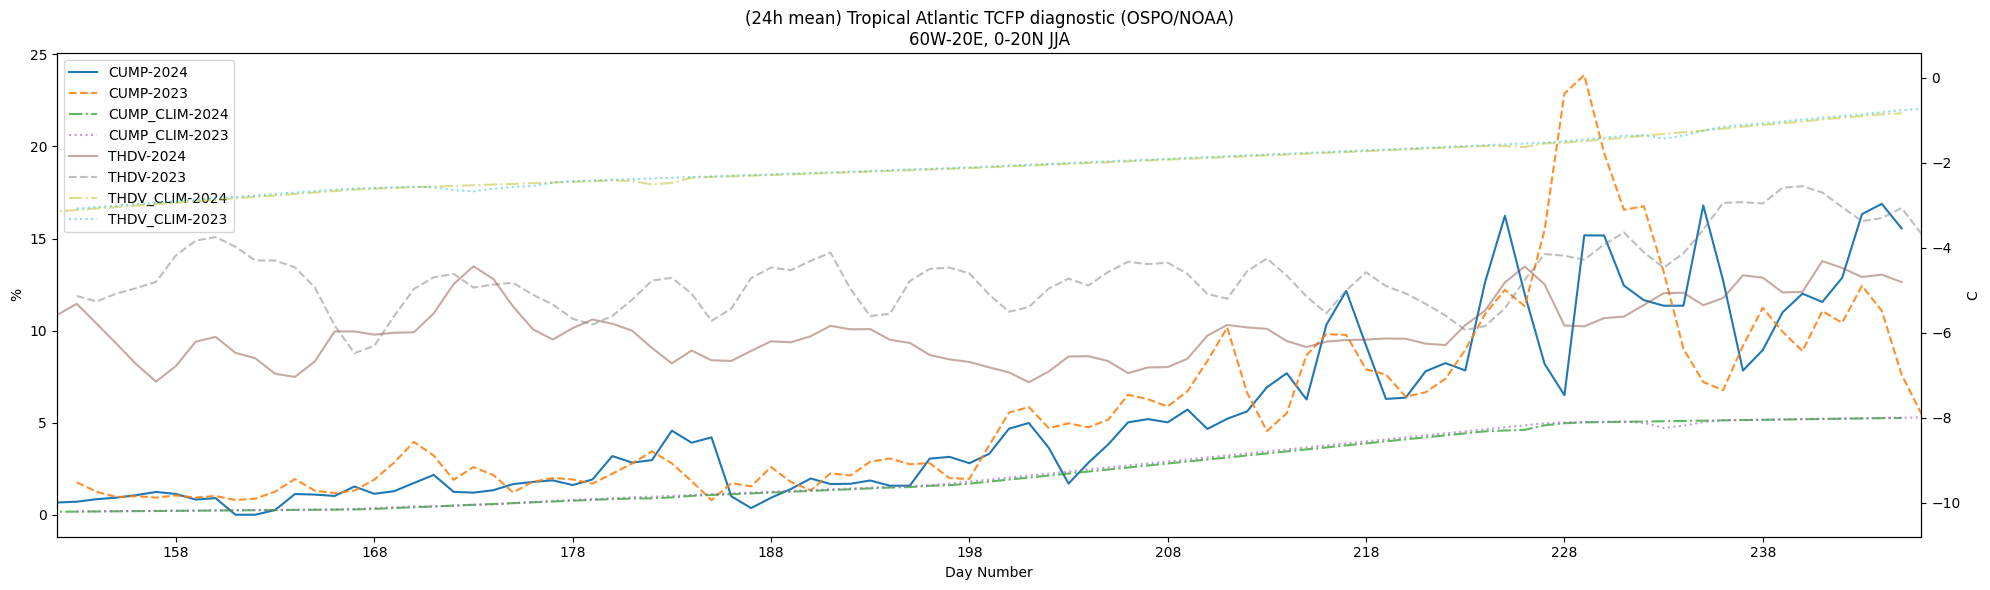

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

def add_legends(ax1, ax2):
    """Add legends to the axes."""
    lines, labels = ax1.get_legend_handles_labels()
    if ax2:
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines.extend(lines2)
        labels.extend(labels2)
    ax1.legend(lines, labels, loc='best')
    
def configure_axes(ax1, ax2, start_date, end_date, variables_to_plot):
    """Configure the axes labels, limits, and tick formatting."""
    # Set x-axis limits to day_of_year
    ax1.set_xlim([start_date.timetuple().tm_yday - 1, end_date.timetuple().tm_yday + 1])
    if ax2:
        ax2.set_xlim([start_date.timetuple().tm_yday - 1, end_date.timetuple().tm_yday + 1])

    # Set x-axis major locator and formatter
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%j'))

def prepare_plotting_data(variables_to_plot):
    """Prepare data and colors for plotting."""
    total_series = sum(len(split_data_by_year(df)) for df in variables_to_plot.values())
    #colors = plt.cm.viridis(np.linspace(0, 1, total_series))
    #colors = plt.cm.plasma(np.linspace(0, 1, total_series))  # Example with 'plasma'

    # Use a discrete colormap like 'tab10'
    cmap = plt.get_cmap('tab10', total_series)
    colors = cmap(np.arange(total_series))

    # Calculate opacity based on the number of series
    def calculate_opacity(i, total):
        return max(0.5, 1 - (i / total))  # Decrease opacity with the number of series

    return colors, calculate_opacity

def split_data_by_year(df):
    """Split data into separate DataFrames for each year."""
    #years = df['forecast_time'].dt.year.unique()
    #return {year: df[df['forecast_time'].dt.year == year] for year in years}
    years = df['smoothed_time'].dt.year.unique()
    return {year: df[df['smoothed_time'].dt.year == year] for year in years}


def filter_and_prepare_data(region, variables, start_date, end_date, smooth_hours=0, aggregation='mean'):
    """Filter, smooth, and prepare data for given variables and date range."""
    subregion_df, cyclone_df, regions_df, variables_df, units_df, variable_units_df = load_parquet_files()
    
    subregion_df = subregion_df[subregion_df.region == region]

    # Remove '24 TO 48 HOURS' rows and keep only '0 TO 24 HOURS'
    subregion_df = subregion_df[subregion_df['period'] == '0 TO 24 HOURS']

    # Drop the 'period' column as it's no longer needed
    subregion_df = subregion_df.drop(columns=['period'])

    # Parse date strings into datetime objects
    start_date = datetime.strptime(start_date, '%Y/%m/%d')
    end_date = datetime.strptime(end_date, '%Y/%m/%d')

    # Filter DataFrames based on the time range
    mask = (subregion_df['forecast_time'] >= start_date) & (subregion_df['forecast_time'] <= end_date)
    filtered_df = subregion_df[mask].copy()  # Explicitly create a copy to avoid SettingWithCopyWarning
    
    # Convert forecast_time to day_of_year for plotting purposes
    filtered_df['day_of_year'] = filtered_df['forecast_time'].dt.dayofyear
    
    # Apply smoothing if specified
    if smooth_hours > 0:
        # Round forecast_time to the nearest smoothing interval (e.g., 6, 12, 24 hours)
        filtered_df['smoothed_time'] = filtered_df['forecast_time'].dt.floor(f'{smooth_hours}H')
        
        # Group by the smoothed time and apply the chosen aggregation function
        if aggregation == 'mean':
            filtered_df = filtered_df.groupby(['smoothed_time', 'variable']).agg({'value': 'mean'}).reset_index()
        elif aggregation == 'min':
            filtered_df = filtered_df.groupby(['smoothed_time', 'variable']).agg({'value': 'min'}).reset_index()
        elif aggregation == 'max':
            filtered_df = filtered_df.groupby(['smoothed_time', 'variable']).agg({'value': 'max'}).reset_index()
        
        # Convert smoothed_time to day_of_year for plotting
        filtered_df['day_of_year'] = filtered_df['smoothed_time'].dt.dayofyear
    else:
        # If no smoothing, keep original data
        filtered_df['smoothed_time'] = filtered_df['forecast_time']
        
    # analyze_data(filtered_df, 'value', variables)

    # Filter the data for the given variables
    variable_units = variable_units_df.set_index('variable')['unit'].to_dict()
    variables_to_plot = {var: filtered_df[filtered_df['variable'] == var] for var in variables if var in variable_units}
    
    # Sort data by day_of_year
    for var in variables_to_plot:
        variables_to_plot[var] = variables_to_plot[var].sort_values(by='day_of_year')
    
    return variables_to_plot, variable_units

def plot_series(ax, df, var, color, linestyle, alpha, label, y_axis_label, plot_type='line'):
    """Plot a series on the given axis."""
    if plot_type == 'line':
        ax.plot(df['day_of_year'], df['value'], label=label, linestyle=linestyle, color=color, alpha=alpha)
    elif plot_type == 'point':
        ax.scatter(df['day_of_year'], df['value'], label=label, color=color, alpha=alpha, s=10)
    
    ax.set_ylabel(y_axis_label)

def plot_time_series(region, variables, start_date, end_date, smooth_hours=0, aggregation='mean'):
    """Plot time series for given variables and time range with optional smoothing."""
    variables_to_plot, variable_units = filter_and_prepare_data(region, variables, start_date, end_date, smooth_hours, aggregation)

    
    # Determine units and axes
    units = set(variable_units.get(var) for var in variables_to_plot)
    if len(units) > 2:
        raise ValueError("Too many different units. Restrict to variables with at most 2 different units.")
    
    units_order = ['%', 's-1', 'ms-1', 'C', 'hPa']
    common_unit = sorted(units, key=lambda u: (units_order.index(u) if u in units_order else len(units_order)))[0]
    other_unit = next(u for u in units if u != common_unit) if len(units) == 2 else None
    
    # Prepare data for plotting
    colors, calculate_opacity = prepare_plotting_data(variables_to_plot)
    
    # Plot the data
    fig, ax1 = plt.subplots(figsize=(20, 6))
    ax2 = ax1.twinx() if other_unit else None
    
    line_styles = ['-', '--', '-.', ':']
    color_index = 0

    # Choose plot type based on smooth_hours
    plot_type = 'line' if smooth_hours > 0 else 'point'

    # Plot each variable
    for var, df in variables_to_plot.items():
        split_data = split_data_by_year(df)
        for year, year_df in split_data.items():
            label = f"{var}-{year}"
            color = colors[color_index % len(colors)]
            linestyle = line_styles[color_index % len(line_styles)]
            alpha = calculate_opacity(color_index, len(colors))
            
            # Plot on the appropriate axis
            if variable_units[var] == common_unit:
                plot_series(ax1, year_df, var, color, linestyle, alpha, label, common_unit, plot_type)
            else:
                if not ax2:
                    ax2 = ax1.twinx()  # Create a secondary y-axis if needed
                plot_series(ax2, year_df, var, color, linestyle, alpha, label, other_unit, plot_type)
            color_index += 1
    
    configure_axes(ax1, ax2, datetime.strptime(start_date, '%Y/%m/%d'), datetime.strptime(end_date, '%Y/%m/%d'), variables_to_plot)
    add_legends(ax1, ax2)
    
    region_range_str = get_region_range_str(region)
    if smooth_hours == 0:
        ax1.set_title(f'{region} TCFP diagnostic (OSPO/NOAA){region_range_str} JJA')
    else:
        ax1.set_title(f'({smooth_hours}h {aggregation}) {region} TCFP diagnostic (OSPO/NOAA){region_range_str} JJA')
    
    ax1.set_xlabel('Day Number')
    
    plt.tight_layout()
    plt.savefig('tcfp_analysis_vertical_instability_and_cumulative_potential_JJA.png')
    plt.show()
    

def get_region_range_str(region):
    if region == 'Tropical Atlantic':
        region_str = '60W-20E, 0-20N'
    if region_str:
        return f'\n{region_str}'
    else:
        return ''

def calculate_max_value(df, column_name):
    """Calculate the maximum value in the specified column."""
    return df[column_name].max()


def calculate_min_value(df, column_name):
    """Calculate the maximum value in the specified column."""
    return df[column_name].min()

def check_runs_above_threshold(df, variable, column_name, threshold):
    """Check for runs of data where the average is greater than the threshold."""
    runs_above_threshold = []
    # Find runs of data where the average is above the threshold
    above_threshold = df[column_name] > threshold
    run_start = None
    
    for i, is_above in enumerate(above_threshold):
        if is_above and run_start is None:
            run_start = i
        elif not is_above and run_start is not None:
            run_end = i - 1
            runs_above_threshold.append((run_start, run_end))
            run_start = None
    
    # If there was a run that ended at the last row
    if run_start is not None:
        runs_above_threshold.append((run_start, len(df) - 1))
    
    return runs_above_threshold

def analyze_data(main_df, column_name, variables):
    for variable in variables:
        """Analyze data to check for runs where the average exceeds 5% of the maximum value."""
        df = main_df[main_df.variable == variable]
        max_value = calculate_max_value(df, column_name)
        min_value = calculate_min_value(df, column_name)
        threshold = 5
        
        
        """Check if there are any NaN values in the DataFrame."""
        has_nan = df.isna().any().any()
        if has_nan:
            print(f"{variable}: There are NaN values in the DataFrame.")
        else:
            print(f"{variable}: There are no NaN values in the DataFrame.")

        print(f"{variable}: Min Value: {min_value}")
        print(f"{variable}: Maximum Value: {max_value}")

        runs_above_threshold = check_runs_above_threshold(df, variable, column_name, threshold)

        if runs_above_threshold:
            num_runs = len(runs_above_threshold)
            print(f"{variable}: Runs where average exceeds 5% of the maximum value: {num_runs}")

        else:
            print(f"{variable}: No runs where the average exceeds 5% of the maximum value.")

# Example usage
# Assume filtered_df is your DataFrame with forecast_time and value columns
#filtered_df = pd.DataFrame({
#    'forecast_time': pd.date_range(start='2023-01-01', periods=100, freq='6H'),
#    'value': np.random.rand(100) * 100  # Example data
#})

    

# Example usage:
region = 'Tropical Atlantic'
start_date = '2023/06/01'
end_date = '2024/08/31'
variable_names = ['TCFP', 'CUMP', 'CUMP_CLIM', 'THDV', 'THDV_CLIM']
variable_names = ['CUMP', 'CUMP_CLIM', 'THDV', 'THDV_CLIM']
#variable_names = ['HDIV', 'HDIV_CLIM']

"""plot_time_series(region, variable_names, start_date, end_date, smooth_hours=0, aggregation='min')
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=12, aggregation='min')
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=24, aggregation='min')

plot_time_series(region, variable_names, start_date, end_date, smooth_hours=0, aggregation='max')
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=12, aggregation='max')
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=24, aggregation='max')

plot_time_series(region, variable_names, start_date, end_date, smooth_hours=0, aggregation='mean')
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=12, aggregation='mean')
"""
plot_time_series(region, variable_names, start_date, end_date, smooth_hours=24, aggregation='mean')
